<a href="https://colab.research.google.com/github/nanochiplab/Yapay_Sinir_Aglari/blob/main/Face_Mask_Detection_Final_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1.Gerekli Kütüphanelerin Yüklenmesi
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D # Added GlobalAveragePooling2D
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split



In [2]:
# 2.	Veri Seti Yükleme
#Face Mask Detection Dataset’i yükleyiniz.
#https://www.kaggle.com/datasets/omkargurav/face-mask-dataset

from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/Yapay Sinir Ağları/Face Mask/data'  # Google Drive'daki klasör yolunu belirtin
os.chdir(data_dir)

Mounted at /content/drive


In [3]:
images = []
labels = []

# Define a target size for all images
target_size = (224, 224)  # Example size, adjust as needed

for folder_name in os.listdir(data_dir):
    # Skip if it's not a directory (like model weight files)
    if not os.path.isdir(os.path.join(data_dir, folder_name)):
        continue

    label = folder_name
    folder_path = os.path.join(data_dir, folder_name)
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)

            # Read and resize the image
            image = cv2.imread(image_path)
            image = cv2.resize(image, target_size)  # Resize to target size

            images.append(image)
            labels.append(label)

images = np.array(images)
labels = np.array(labels)

print('Dosyalar başarıyla yüklendi.')


Dosyalar başarıyla yüklendi.


In [4]:
# 3.	Önceden Eğitilmiş (Pre-trained) Modellerin Hazırlanması
# Sınıflandırıcı olarak DenseNet121 (pre-trained) modelini kullanacağız....
# Base modeller indirildikten sonra 2 dense katmanı ve bir dropout katmanı ekledik...

from tensorflow.keras.applications import DenseNet121, MobileNet # Changed MobileNetV1 to MobileNet

# 4. Verilerimizi eğitim ve test kümelerine ayırdık..%80 eğitim ve %20 test verisi yapıyoruz...
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [7]:

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import categorical_crossentropy

# optimizer = Adam(learning_rate=0.001)  # İsteğe bağlı olarak öğrenme oranını ayarlayabilirsiniz..
# 0.001'de çok düşük accuracy ve
optimizer = Adam(learning_rate=0.001)
#optimizer = SGD(learning_rate=0.01, momentum=0.7)  # İsteğe bağlı olarak öğrenme oranını ve momentumu ayarlayabilirsiniz

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

# Modelin en iyi ağırlıklarını kaydetmek için ModelCheckpoint geri çağırmasını oluşturun
checkpoint = ModelCheckpoint('best_model_Denseweights.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)


In [8]:
# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder
# Sınıf sayısını belirtin
num_classes = 2  # Örnek olarak 2 sınıf olduğunu varsayalım

# --- DenseNet121 modeli ---
#base_model_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model_densenet.layers:
    layer.trainable = False

x = base_model_densenet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

# İsteğe bağlı olarak Dense katmanlarını ayarlayabilirsiniz
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)


predictions_densenet = Dense(2, activation='softmax')(x)

model_densenet = Model(inputs=base_model_densenet.input, outputs=predictions_densenet)
model_densenet.compile(optimizer=optimizer, loss=categorical_crossentropy, metrics=['accuracy'])

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder to your labels and transform them
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#****************************************************************************************************
# Hedef etiketleri kategorik veriye dönüştürmek için one-hot encoding kullanacağız...
from tensorflow.keras.utils import to_categorical  # Import to_categorical
y_train_encoded = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_encoded = to_categorical(y_test_encoded, num_classes=num_classes)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=25)
# Model eğitimi sırasında veri arttırmayı kullanın
# Veri arttırma parametrelerini ayarlayın
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

history_densenet = model_densenet.fit(
    datagen.flow(X_train, y_train_encoded, batch_size=32),
    epochs=100,
    validation_data=(X_test, y_test_encoded),
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Veri arttırmayı eğitim verisine uygulayın
datagen.fit(X_train)

# --- Modelleri değerlendirin ---
loss_densenet, accuracy_densenet = model_densenet.evaluate(X_test, y_test_encoded) # Use y_test_encoded

print("DenseNet121 - Loss:", loss_densenet, "Accuracy:", accuracy_densenet)
#********************************************************************************************************
# Şimdi eğitim ve değerlendirme için y_train_encoded and y_test_encoded kullanacağız
#history_mobilenet = model_mobilenet.fit(X_train, y_train_encoded, epochs=100, batch_size=32, validation_split=0.2)

# --- Modelleri değerlendiriyoruz ---
#loss_mobilenet, accuracy_mobilenet = model_mobilenet.evaluate(X_test, y_test_encoded) # Use y_test_encoded

#print("MobileNetV1 - Loss:", loss_mobilenet, "Accuracy:", accuracy_mobilenet)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9022 - loss: 0.2295
Epoch 1: val_accuracy improved from -inf to 0.48515, saving model to best_model_Denseweights.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 107s 448ms/step - accuracy: 0.9024 - loss: 0.2290 - val_accuracy: 0.4851 - val_loss: 14.1775 - learning_rate: 0.0010
Epoch 2/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9657 - loss: 0.1065
Epoch 2: val_accuracy improved from 0.48515 to 0.49505, saving model to best_model_Denseweights.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 60s 314ms/step - accuracy: 0.9657 - loss: 0.1065 - val_accuracy: 0.4950 - val_loss: 5.6271 - learning_rate: 0.0010
Epoch 3/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9721 - loss: 0.0835
Epoch 3: val_accuracy did not improve from 0.49505
190/190 ━━━━━━━━━━━━━━━━━━━━ 59s 309ms/step - accuracy: 0.9721 - loss: 0.0835 - val_accuracy: 0.4878 - val_loss: 7.1608 - learning_rate: 0.0010
Epoch 4/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 299

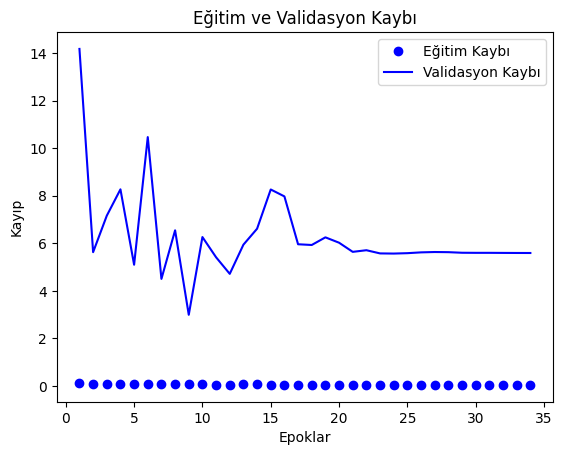

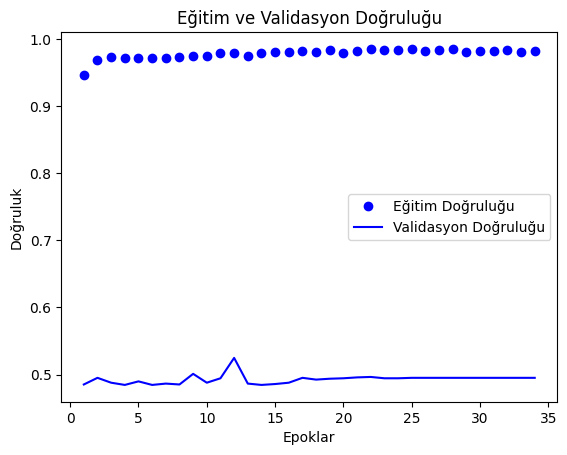

In [9]:
import matplotlib.pyplot as plt

#Her epok sonunda eğitim kaybı (loss) ve doğruluğu (accuracy) ile validasyon kaybı ve doğruluğunu kaydedin ve eğriyi çizdirin
# Eğitim geçmişini kaydet
loss = history_densenet.history['loss']
accuracy = history_densenet.history['accuracy']
val_loss = history_densenet.history['val_loss']
val_accuracy = history_densenet.history['val_accuracy']


epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Eğitim Kaybı')
plt.plot(epochs, val_loss, 'b', label='Validasyon Kaybı')
plt.title('Eğitim ve Validasyon Kaybı')
plt.xlabel('Epoklar')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

plt.plot(epochs, accuracy, 'bo', label='Eğitim Doğruluğu')
plt.plot(epochs, val_accuracy, 'b', label='Validasyon Doğruluğu')
plt.title('Eğitim ve Validasyon Doğruluğu')
plt.xlabel('Epoklar')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 271ms/step


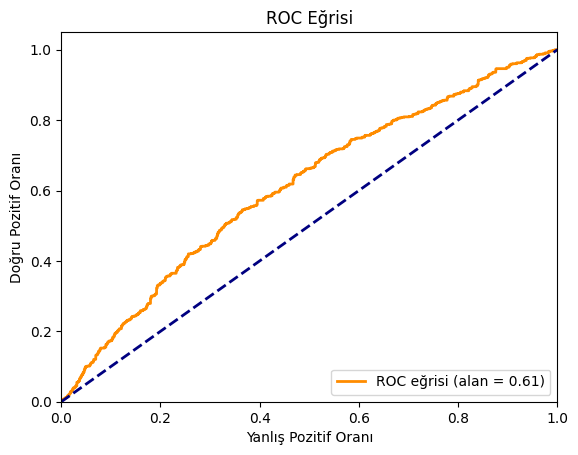

AUC: 0.6090302030164639


In [10]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# En iyi ağırlıkları yükleyin
model_densenet.load_weights('best_model_Denseweights.keras')

# Fit the encoder to your original labels (if not already done)
label_encoder.fit(labels)  # 'labels' is your original label array

# Transform y_test to numerical labels
y_test_numeric = label_encoder.transform(y_test)
#*************************************************************

# Tahminleri olasılıklara dönüştürün
#ROC eğrisi veya AUC gibi metrikleri hesaplamak istiyorsak, genellikle pozitif sınıfın olasılıklarına ([:, 1] çıktısına) ihtiyaç duyacağız
#Bu durumda, y_pred_probs = model_mobilenet.predict(X_test)[:, 1] kodunu kullanmamız gerekiyor....
y_pred_probs = model_densenet.predict(X_test)[:, 1]

# ROC eğrisi ve AUC değerini hesaplayın
fpr, tpr, thresholds = roc_curve(y_test_numeric, y_pred_probs)  # Use y_test_numeric here
roc_auc = auc(fpr, tpr)


# ROC eğrisi ve AUC değerini hesaplayın
#fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
#roc_auc = auc(fpr, tpr)

# ROC eğrisini çizdirin
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC eğrisi (alan = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Yanlış Pozitif Oranı')
plt.ylabel('Doğru Pozitif Oranı')
plt.title('ROC Eğrisi')
plt.legend(loc="lower right")
plt.show()

# AUC değerini yazdırın
print('AUC:', roc_auc)

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
Confusion Matrix:
 [[676  58]
 [662 119]]


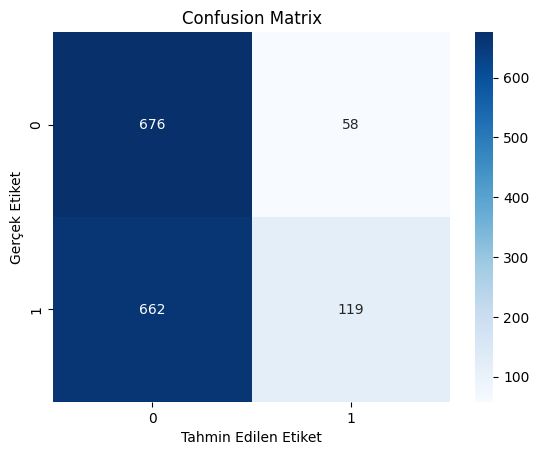

Accuracy: 0.5247524752475248
Precision: 0.672316384180791
Recall: 0.1523687580025608
Specificity: 0.9209809264305178
F1-score: 0.24843423799582465


In [11]:
# Tahminleri sınıflara dönüştürün
y_pred = np.argmax(model_densenet.predict(X_test), axis=1)

# Use LabelEncoder to transform y_test to numerical labels before calculating the confusion matrix
y_test_numeric = label_encoder.transform(y_test)

# Confusion Matrix'i hesaplayın ve yazdırın
cm = confusion_matrix(y_test_numeric, y_pred)  # Use y_test_numeric here
print('Confusion Matrix:\n', cm)

# Confusion matrix'i çizdiriyoruz..
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Tahmin Edilen Etiket")
plt.ylabel("Gerçek Etiket")
plt.show()

# Accuracy, Precision, Recall, Specificity ve F1-score'u hesaplayın ve yazdırın
accuracy = accuracy_score(y_test_numeric, y_pred)  # Use y_test_numeric here
precision = precision_score(y_test_numeric, y_pred)  # Use y_test_numeric here
recall = recall_score(y_test_numeric, y_pred)  # Use y_test_numeric here
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # TN / (TN + FP)
f1 = f1_score(y_test_numeric, y_pred)  # Use y_test_numeric here

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('Specificity:', specificity)
print('F1-score:', f1)